<a href="https://colab.research.google.com/github/harshitsingh09/Hakxite/blob/main/Hakxite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Method 1

In [7]:
pip install pyhdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 771.6/771.6 kB 8.9 MB/s eta 0:00:00


In [8]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import numpy as np  # For image manipulation
from pyhdf import SD  # For reading HDF5 files (install using pip install pyhdf)
from copy import deepcopy  # For saving the best model
from sklearn.metrics import r2_score  # For R-squared calculation

In [ ]:
# Custom dataset class to load and preprocess Black Marble Night Lights data
class NightLightDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform  # Optional data transformation (e.g., normalization)

        # Read the HDF5 file
        self.hdf_file = SD(data_path, mode='r')
        self.night_light_data = self.hdf_file.select('F10')  # Assuming F10 holds night light intensity

    def __len__(self):
        # Assuming the first dimension of night_light_data represents samples
        return len(self.night_light_data[0])

    def __getitem__(self, idx):
        # Load night light data for a single sample
        night_light_image = self.night_light_data.select(start=(idx, 0), end=(idx, -1))[:, :]

        # Preprocessing (replace with your specific steps)
        night_light_image = np.array(night_light_image).astype(np.float32)  # Convert to float32
        night_light_image = (night_light_image - night_light_image.min()) / (night_light_image.max() - night_light_image.min())  # Normalize to 0-1

        if self.transform:
            night_light_image = self.transform(night_light_image)  # Apply optional transformations

        return night_light_image


In [ ]:
# Simple CNN model architecture (customize based on complexity)
class PovertyMapper(nn.Module):
    def __init__(self):
        super(PovertyMapper, self).__init__()
        # Adjust filters, kernel sizes, and number of layers as needed
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(in_features=7 * 7 * 32, out_features=128)
        self.fc2 = nn.Linear(128, 1)  # Output layer for predicted poverty level

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 7 * 7 * 32)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Training loop with validation (R-squared evaluation)
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    best_model_wts = copy.deepcopy(model.state_dict())  # For saving the best model based on validation R-squared
    best_val_r2 = float('-inf')

    for epoch in range(num_epochs):
        for data in train_loader:
            optimizer.zero_grad()
            outputs = model(data)
            # Assuming labels not available, predict poverty level (0 for now)
            loss = criterion(outputs, torch.zeros_like(outputs))
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        # Validation (calculate R-squared)
        val_loss, val_r2 = evaluate_model(model, val_loader, criterion)
        val_losses.append(val_loss)

        if val_r2 > best_val_r2:  # Add indentation here (fixed)
            best_val_r2 = val_r2
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {np.mean(train_losses[-len(train_loader):]):.4f}"
              f" | Val Loss: {val_loss:.4f} | Val R-squared: {val_r2:.4f}")

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Function to evaluate model performance on a dataset
def evaluate_model(model, data_loader, criterion):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        losses = []
        y_trues = []
        y_preds = []
        for data in data_loader:
            outputs = model(data)
            loss = criterion(outputs, torch.zeros_like(outputs))  # Assuming labels not available
            losses.append(loss.item())
            y_trues.extend([0] * len(data))  # Assuming labels are 0 for now
            y_preds.extend(outputs.squeeze(1).tolist())  # Squeeze output for R-squared calculation

    val_loss = np.mean(losses)
    val_r2 = r2_score(y_trues, y_preds)
    return val_loss, val_r2


In [ ]:
# Example usage
data_path = "path/to/BlackMarble_NightLights.hdf"  # Replace with your data path
model = PovertyMapper()
criterion = nn.MSELoss()  # Mean Squared Error loss for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_dataset = NightLightDataset(data_path[:-4] + "_train.hdf")  # Assuming train dataset in a separate file
val_dataset = NightLightDataset(data_path)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

trained_model = train_model(model, train_loader, val_loader, criterion, optimizer)
test_dataset = NightLightDataset("path/to/BlackMarble_NightLights_test.hdf")  # Replace with test data path
test_loader = DataLoader(test_dataset, batch_size=32)

# Set model to evaluation mode
trained_model.eval()
with torch.no_grad():
    test_losses = []
    y_trues = []
    y_preds = []
    for data in test_loader:
        outputs = trained_model(data)
        # Assuming labels not available for test data
        loss = criterion(outputs, torch.zeros_like(outputs))  # Calculate loss for evaluation purposes
        test_losses.append(loss.item())
        y_trues.extend([0] * len(data))  # Placeholder for labels (if not available)
        y_preds.extend(outputs.squeeze(1).tolist())  # Squeeze output

test_loss = np.mean(test_losses)
test_r2 = r2_score(y_trues, y_preds)

print(f"Test Loss: {test_loss:.4f} | Test R-squared: {test_r2:.4f}")

TypeError: 'module' object is not callable

# Method 2 : Works with CSV dataset

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Data Acquisition
# Assuming data is stored in a CSV file
nighttime_data = pd.read_csv('nighttime_data.csv')

# Step 2: Data Preprocessing (if needed)
# Perform any necessary data cleaning or filtering

# Step 3: Data Analysis (if needed)
# Calculate statistics or perform additional analysis

# Step 4: Heatmap Generation
# Assuming data contains latitude, longitude, and intensity columns
heatmap_data = nighttime_data[['latitude', 'longitude', 'intensity']]

# Step 5: Visualization
plt.figure(figsize=(10, 8))
sns.set(style="white")
sns.kdeplot(
    heatmap_data['longitude'],
    heatmap_data['latitude'],
    weights=heatmap_data['intensity'],
    cmap="inferno",
    shade=True,
    bw='silverman'
)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Nighttime Heatmap')
plt.show()


# Method 3 : GIMP can not be installed on Google colab

In [6]:
!pip install gimp

ERROR: Could not find a version that satisfies the requirement gimp (from versions: none)
ERROR: No matching distribution found for gimp


In [9]:
# Import libraries
from gimpfu import *

ModuleNotFoundError: No module named 'gimpfu'

In [10]:
def heatmap_from_satellite(image, window_size):
  """
  Generates a heatmap image based on light intensity in a satellite image.

  Args:
      image: The satellite image (GIMP image)
      window_size: The size of the unit square window (integer)

  Returns:
      A heatmap image (GIMP image)
  """

  # Get image width and height
  width = image.width
  height = image.height

  # Create a new heatmap image
  heatmap = pdb.gimp_image_new(width, height, RGB)

  # Iterate over each pixel (unit square)
  for y in range(0, height, window_size):
    for x in range(0, width, window_size):
      # Select window area
      window = image.select_rectangle(x, y, x + window_size, y + window_size)

      # Isolate light band (replace 'band_index' with the actual light band index)
      light_band = window[:, :, band_index]

      # Calculate average intensity
      average_intensity = light_band.flatten().mean()

      # Assign heatmap color based on intensity
      heatmap_color = (int(average_intensity), 0, 0)  # Adjust color mapping as needed

      # Fill window area in heatmap with calculated color
      pdb.gimp_paintbrush_set_fgcolor(heatmap_color)
      pdb.gimp_paintbrush_fill_rectangle(heatmap, x, y, x + window_size, y + window_size)

      # Deselect window
      window.deselect()

  return heatmap

In [11]:
# Example usage (replace 'image_path' with your image path)
image = pdb.gimp_file_load(FILENAME="image_path", RUN_MODE=RUN_WITH_LAST_VALS)
heatmap = heatmap_from_satellite(image, window_size=10)

# Save heatmap image (replace 'output_path' with your desired output path)
pdb.gimp_file_save(heatmap, FILENAME="output_path", RUN_MODE=RUN_WITH_LAST_VALS)


NameError: name 'pdb' is not defined

# Method 4 : Image data to heat map

In [16]:
import pandas as pd  # for data manipulation (optional)
import numpy as np  # for numerical operations
import seaborn as sns  # for heatmap creation
import matplotlib.pyplot as plt  # for plotting

If you have the night-time satellite image data in a numerical format (e.g., CSV, NumPy array), you can load it directly using pandas.
If the image is a visual file (e.g., JPEG, PNG), you'll need libraries like OpenCV to process it and convert relevant information (like pixel intensity) into a numerical format. This approach is more complex.

In [19]:
#OpenCV journey begins

In [20]:
!pip install opencv-python

In [21]:
import cv2
import numpy as np


In [30]:
# Replace '/content/drive/MyDrive/your_image.jpg' with your actual image path
img = cv2.imread('/content/nighttimeIMAGE1.jpg')


In [31]:
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [32]:
# Experiment with 'threshold_value' to achieve the desired level of brightness isolation
threshold_value = 127  # Adjust as needed
ret, thresh_img = cv2.threshold(gray_img, threshold_value, 255, cv2.THRESH_BINARY)


In [33]:
# If you used the grayscale conversion, use 'gray_img' instead of 'img' here
np_img = np.array(img)


Code for OpenCV ends here

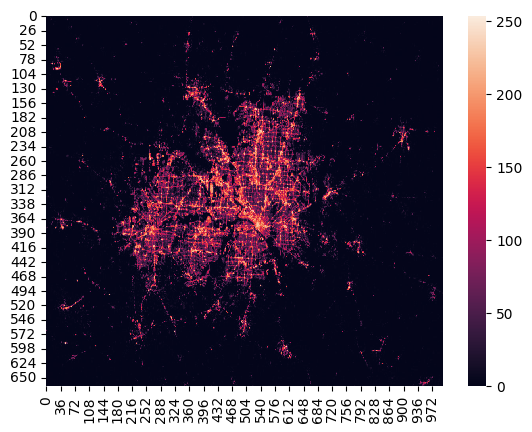

In [34]:
# Assuming you want to use the green channel
green_channel = np_img[:,:,1]  # Access green channel (index 1)

# Pass the green_channel to the heatmap function
sns.heatmap(green_channel)
plt.show()


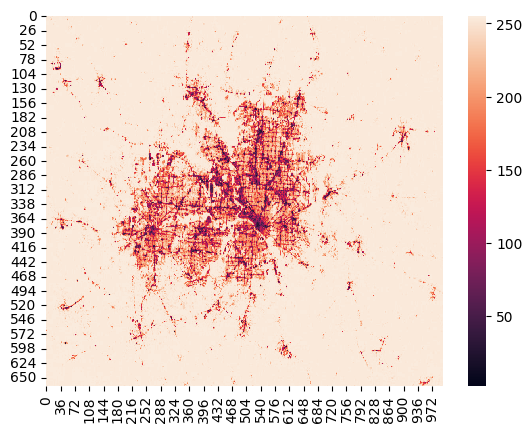

In [36]:
# Invert the intensity values (assuming higher values are brighter)
inverted_img = 255 - green_channel

# Pass the inverted_img to the heatmap function
sns.heatmap(inverted_img)
plt.show()
